# Variational ansatz-based quantum simulation of imaginary time evolution

## Introduction
This [paper](https://www.nature.com/articles/s41534-019-0187-2) proposed ansatz-based imaginary time evolution method for optimizing VQE. In this paper recurrence, we implement this method, and reproduce the experiment on LiH and H2 system.

In [ ]:
!pip install openfermion

In [ ]:
!pip install openfermionpyscf

In [ ]:
!pip install PennyLane-Qchem

In [ ]:
## 安装最新版Minduantum

!pip install https://hiq.huaweicloud.com/download/mindquantum/newest/linux/mindquantum-master-cp37-cp37m-linux_x86_64.whl -i https://pypi.tuna.tsinghua.edu.cn/simple

In [ ]:
import numpy as np
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf
import mindquantum as mq
from mindquantum import Hamiltonian
from mindquantum import Circuit, RY, RX, RZ
from mindquantum import X, Z, Y

# from mindquantum.algorithm.nisq.chem import generate_uccsd
from mindquantum.simulator import Simulator
from mindquantum.algorithm.nisq.chem import get_qubit_hamiltonian
from mindquantum.core import ParameterResolver
from mindquantum.core.parameterresolver import ParameterResolver as PR
import math
from mindquantum.core.operators import QubitOperator

<!-- <script
  src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML"
  type="text/javascript">
</script>
 -->



### Theory: 
Ansatz-based imaginary time evolution(AITE), or imaginary-time Ansatz optimization(as refered in [Ref](https://www.nature.com/articles/s41567-019-0704-4)) is a method to project the trajectory of imaginary time evolution onto the ansatz manifold. The basic idea is to solve the imaginary time evolution equation(McLachlan’s variational principle): $$\frac{\partial |\psi(\tau)\rangle}{\partial \tau} = -(H - E_{\tau})|\psi(\tau)\rangle$$

Where $$E_{\tau} = \langle \psi(\tau)|H|\psi(\tau) \rangle$$ 

What makes it different from conventional imaginary time evolution method is that it uses the function space of ansatz $\theta \mapsto |\psi_{\theta}(\tau)\rangle$ as the solution space. By doing so, the evolution of state vector $|\psi \rangle$ is transformed into evolution of parameters $\theta$. For more details, please refer to the Appendix of the [paper](https://www.nature.com/articles/s41534-019-0187-2).

In short, the AITE is to obey the following update rule:
$$\theta(\tau + \delta \tau) = \theta(\tau) + A^{-1}(\tau) \cdot C(\tau)\delta \tau$$

Where 

$$A_{ij}(\tau) = \mathrm{Real}\left(\frac{\partial \langle \phi(\tau)|}{\partial \theta_i} \frac{\partial |\phi(\tau) \rangle}{\partial \theta_j}\right)$$
$$C_{i}(\tau) = -\mathrm{Real} \left(\frac{\partial \langle \phi(\tau)|}{\partial \theta_i} H  |\phi(\tau) \rangle \right)$$

This is actually equivalent to applying a preconditioner $A^{-1}$ to the gradient descent method:
$$\theta(\tau + \delta \tau) = \theta(\tau) - A^{-1}(\tau) \cdot \mathrm{grad}(\theta(\tau))\delta \tau$$

Recent [propose](https://arxiv.org/pdf/1909.02108.pdf) of quantum natural gradient descent(QNGD) also connects to the precontitioner $A$ of AITE. In QNGD, the update rule is as follows:

$$\theta(\tau + \delta \tau) = \theta(\tau) - F^{-1}(\tau) \cdot \mathrm{grad}(\theta(\tau))\delta \tau$$

Where $$F_{ij}(\tau) = 4 \mathrm{Real}\left(\frac{\partial \langle \phi(\tau)|}{\partial \theta_i} \frac{\partial |\phi(\tau) \rangle}{\partial \theta_j} - \frac{\partial \langle \phi(\tau)|}{\partial \theta_i} |\phi(\tau)\rangle \langle \phi(\tau)|  \frac{\partial |\phi(\tau)\rangle}{\partial \theta_j}\right)$$

We see that both AITE and QNGD can be seen as cases for applying Hessian-like preconditioner to the gradient descent method.

<!-- <script
  src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML"
  type="text/javascript">
</script>
 -->
### Calculating gradient of expectation:

* For the calculation of the gradient there are mainly two kinds of approaches in the field of numerical simulation of quantum algorithms:
    + Forward mode approaches, including the parameter-shift method and the indirect measurement
    + Reverse mode approach, which is also called backpropogation in ML literatures
    
The reverse mode works in such a way that during the forward pass of the expectation computation, all intermediate results are stored (note that for reversible operators such as quantum gate, the intermediate results could be recomputed during the reverse pass. Due to reversibility, such storage could be avoided, as [Yao.jl](https://yaoquantum.org/) did), and the gradient is computed by a reverse pass using the chain rule. The advantage of the reverse mode is that only one pass is required to calculate the gradients of all parameters (namely, $\mathcal{O}(1)$ complexity). Due to this low complexity, most quantum simulator(including mindquantum) use this method as default gradient calculator. However, the disadvantage is that since this method exploits the intermediate result (mainly in the form of a wave vector), it could not be implemented experimentally in real quantum computers (the explicit representation of quantum wave vectors consumes exponentially large resources).

The forward mode works in such a way that the form $ \frac{\partial \langle \phi(\tau)|}{\partial \theta_i} |\phi(\tau) \rangle$ can be evaluated directly using quantum circuits. More precisely, considering a quantum state generated with a circuit $\langle \psi| = \langle 0|U_0 U_1 ...U_i(\theta) ... U_n$, the expectation $ \frac{\partial \langle \psi|}{\partial \theta_i} |\psi \rangle$ could be written as:

$$\begin{aligned}
\frac{\partial \langle \psi|}{\partial \theta_i} |\psi\rangle &=  \frac{\partial  \langle 0|U_0 U_1 ...U_i(\theta_i) ... U_n}{\partial \theta_i} |\psi \rangle \\
&=  \langle 0|U_0 U_1 ... \frac{\partial U_i(\theta_i)}{\partial \theta_i} ... U_n |\psi \rangle
\end{aligned}$$


For some cases, $\frac{\partial U_i(\theta_i)}{\partial \theta_i}$ remains linear combination of unitary operators and can be represented by a quantum gate. Taking RX gate for an example, we could write:
$$Rx(\theta) = \partial e^{-i\frac{\theta}{2} X} / \partial \theta = -\frac{i }{2} X Rx(\theta)$$
which is just to append a X gate right before Rx gate.

As a result, the gradient expression could be written in a general form:
$$
\langle 0|U_0 U_1 ... \frac{\partial
                            e^{-i \theta_i U_i}
                            }
                            {\partial \theta_i} ... U_n |\psi \rangle 
 = \langle 0|U_0 U_1 ... (-iU_i e^{-i \theta_i U_i}) ... U_n |\psi \rangle
$$

Different approaches of forward mode use different strategy to evaluate the expectation above. Most experimental work use the method of parameter-shift and indirect measurement(Hadamard-test-like approach). Since these methods could be implemented in a real world quantum computer, they are also called faithful gradient. For more details, please refer to [Ref](https://arxiv.org/abs/1811.11184).

In this implementation, however, we take a simpler approach: we compute the above expected value directly with the quantum simulator. The problem of this approach is that it relies on measuring the imaginary part of the expected value in the circuit measurement. This does not work in a real quantum computer either! However, since we are performing a numerical experiment, we can relax our standards.


### Calculating Hessian-like preconditioner:

<!-- Since forward mode requires one pass for each paramter in the model, we need N pass for N parameters, which is expensive. Most numerical simulation of quantum computing thus use reverse mode. However,  -->

Although reverse mode differetiation brings advantages of low computational complexity, to calculate $\frac{\partial <\phi(\tau)|}{\partial \theta_i} \frac{\partial |\phi(\tau)>}{\partial \theta_j}$, only using reverse mode is not enough(at least in mindquantum framework).

One way to solve this problem is to using $N^2$ forward mode calculation as proposed in most papers, which is a notoriously expensive operation.
Here I propose a new hybrid mode for this calculation: For each parameter $\theta_i$, we firstly setup the expectation target using forward mode(which means the expectation value itself is $\frac{\partial <\phi|\phi>}{\partial \theta_i}$), and then we use reverse model to calculate $\frac{\partial <\phi| \partial |\phi>}{\partial \theta_i \partial \theta_j}$ with respect to all parameter $\theta_j$ through one pass. In this case, only $N$ expectation calculation is needed!

### Implementation
One way to implement the forward mode differentiation is to use the helper function:

In [7]:
import numpy as np
from mindquantum import Circuit, RY, RX, RZ
from mindquantum import X, Z, Y


from mindquantum.simulator import Simulator
from mindquantum.core import ParameterResolver
from mindquantum.core.parameterresolver import ParameterResolver as PR
import math

class Parameter_manager:
    def __init__(self, key='default'):
        self.parameters = []
        self.count = 0
        self.key = key
        self.grad_key = None
    
    def init_parameter_resolver(self):
        pr = {k:np.random.randn()*2*math.pi for k in self.parameters}
        # pr = {k:0 for k in self.parameters}
        pr = ParameterResolver(pr)
        return pr

    def _replay(self):
        self.count = 0

    def set_grad_key(self, key):
        self.grad_key = key
        self._replay()    

    def create(self):
        param = '{}_theta_{}'.format(self.key, self.count)
        self.count += 1
        self.parameters.append(param)
        if self.grad_key is None or param!=self.grad_key:
            is_grad = False
        else:
            is_grad = True
        return param, is_grad


def RY_gate(circ, i, P):
    ry, is_grad = P.create()
    if not is_grad:
        circ += RY(ry).on(i)
    else:
        circ += Y.on(i)
        circ += RY(ry).on(i)

def RX_gate(circ, i, P):
    rx, is_grad = P.create()
    if not is_grad:
        circ += RX(rx).on(i)
    else:
        circ += X.on(i)
        circ += RX(rx).on(i)

def RZ_gate(circ, i, P):
    rz, is_grad = P.create()
    if not is_grad:
        circ += RZ(rz).on(i)
    else:
        circ += Z.on(i)
        circ += RZ(rz).on(i)

def RZZ_gate(circ, i, j, P):
    circ += X.on(j, i)
    RZ_gate(circ, j, P)
    circ += X.on(j, i)

def RYY_gate(circ, i, j, P):
    circ += X.on(j, i)
    RY_gate(circ, j, P)
    circ += X.on(j, i)

def RXX_gate(circ, i, j, P):
    circ += X.on(j, i)
    RX_gate(circ, j, P)
    circ += X.on(j, i)


def layer(C, P, n_qubits):
    for i in range(n_qubits):
        RX_gate(C, i, P)

    for i in range(0, n_qubits-1, 2):
        RZZ_gate(C, i, i+1, P)



from src.Hessian.utils import pr2array
J = np.complex(0,1)
class Gradient_test:
    def __init__(self, n_qubits):
        self.n_qubits = n_qubits
        self.P = Parameter_manager()
        self.circ = Circuit()
        layer(self.circ, self.P, self.n_qubits)
        self.pr = self.P.init_parameter_resolver()
        # _, self.k_list = pr2array(self.pr)
        self.phase_shift = None
        
    def determine_phase_shift(self, ham):
        # self.phase_shift = -1
        jac, _ = self._gradient(ham, 1)
        jac_reverse = self.grad_reserveMode(ham)
        self.phase_shift = jac.mean() / jac_reverse.mean()
        self.pahse_shift = self.phase_shift / np.abs(self.phase_shift)
        
    def gradient(self, ham):
        if self.phase_shift is None:
            self.determine_phase_shift(ham)
        return self._gradient(ham, self.phase_shift)
        
    def _gradient(self, ham, phase_shift):
        coeff = (-1./2) * J
        parameters, k_list = pr2array(self.pr)
        jac = np.zeros(len(parameters)).astype(np.complex)
        hess = np.zeros((len(parameters), len(parameters))).astype(np.complex)

        for i, ki in enumerate(k_list):

            self.P.set_grad_key(ki)
            circ_right = Circuit()
            layer(circ_right, self.P, self.n_qubits)

            sim = Simulator('projectq', self.n_qubits)
            circ_right.no_grad()

            grad_ops = sim.get_expectation_with_grad(ham, circ_right, self.circ)
            e, g = grad_ops(parameters)

            jac[i] = e[0][0] * coeff #this is \partial E/ \partial circ_right
            hess[i] = g.squeeze() * coeff * (-1) * phase_shift #* J

        jac = jac * 2 * phase_shift #+ jac * J # add h.c.
        return jac.real, hess.real

    def grad_reserveMode(self, ham):
        r'''
        test method that generate gradient using backpropogation(reverse mode differentiation)
        '''
        parameters, k_list = pr2array(self.pr)
        
        sim = Simulator('projectq', self.n_qubits)
        grad_ops = sim.get_expectation_with_grad(ham, self.circ, self.circ)
        e, g = grad_ops(parameters)
        return g.squeeze().real
    
from src.Hessian.utils import Ising_like_ham
n_qubits = 5
Ham = Ising_like_ham(n_qubits)
ham = Ham.local_Hamiltonian()

gt = Gradient_test(n_qubits)
jac_helper, hess_helper = gt.gradient(ham)
print(jac_helper)
print(hess_helper)

[-0.20658813 -0.42379512 -0.63145202  0.14640748 -0.6406928   0.01639253
  0.11488007]
[[-2.89971526e-01 -2.35919173e-01  2.77555756e-17 -1.04083409e-17
   1.38777878e-17  3.28582013e-02 -2.57162793e-02]
 [-2.35919173e-01  9.18836881e-04 -8.04148993e-02 -3.40838216e-18
  -1.88380127e-17  3.28582013e-02 -2.57162793e-02]
 [-0.00000000e+00 -8.04148993e-02  5.71392453e-01  5.44532086e-02
  -7.80625564e-18 -1.32921774e-02  1.19320386e-01]
 [-3.46944695e-18  3.24452975e-18  5.44532086e-02  2.61337372e-02
   7.79650798e-02 -1.32921774e-02  1.19320386e-01]
 [-2.77555756e-17 -3.70962084e-17 -1.03539315e-17  7.79650798e-02
  -6.38736102e-01  1.35382343e-02 -9.70783812e-02]
 [ 3.28582013e-02  3.28582013e-02 -1.32921774e-02 -1.32921774e-02
   1.35382343e-02 -1.91686906e-01 -1.28518925e-01]
 [-2.57162793e-02 -2.57162793e-02  1.19320386e-01  1.19320386e-01
  -9.70783812e-02 -1.28518925e-01 -1.50748286e-01]]


/home/ma-user/anaconda3/envs/MindQuantum/lib/python3.7/site-packages/ipykernel/__main__.py:92: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/ma-user/anaconda3/envs/MindQuantum/lib/python3.7/site-packages/ipykernel/__main__.py:118: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/ma-user/anaconda3/envs/MindQuantum/li

It works!

However, doing the calculation in this way, we can not take advantage of many mindquantum function to build the circuit. A better way is as follows:

In [8]:
import mindquantum.core.gates as G
from mindquantum.simulator import Simulator
from mindquantum.core.operators import QubitOperator
from mindquantum import Hamiltonian
from mindquantum import Circuit
import copy
import numpy as np

from src.Hessian.utils import pr2array, Ising_like_ham
from src.Hessian.helper import Parameter_manager, layer

def example_circuit(n_qubits=5):
    circ = Circuit()
    P = Parameter_manager()
    layer(circ, P, n_qubits)
    pr = P.init_parameter_resolver()
    return circ, pr

def get_gradient_preconditional(gate):
    if isinstance(gate, G.RX):
        return G.X.on(gate.obj_qubits)
    elif isinstance(gate, G.RY):
        return G.Y.on(gate.obj_qubits)
    elif isinstance(gate, G.RZ):
        return G.Z.on(gate.obj_qubits)
    else:
        raise NotImplementedError()

J = np.complex(0,1)
def grad_circuit_symbolic_forward(circ):
    circ_list, circ_coeff_list = [], []
    for i, gate in enumerate(circ):
        if isinstance(gate, (G.RX, G.RY, G.RZ)):
            n_circ = copy.deepcopy(circ)
            n_circ.insert(i, get_gradient_preconditional(gate))
            circ_list.append(n_circ)
            circ_coeff_list.append(-1./2 * J) #for example, grad(RX) = -j X RX
    return circ_list, circ_coeff_list


PHASE_SHIFT = None

class Grad:
    def __init__(self, circ, pr, ham, n_qubits):
        self.circ, self.pr, self.ham = circ, pr, ham
        self.n_qubits = n_qubits
        self.parameters, self.k_list = pr2array(self.pr)
        self.circ_list, self.circ_coeff_list = grad_circuit_symbolic_forward(self.circ)

        assert len(self.circ_list)==len(self.k_list), '{} vs {}'.format(len(self.circ_list), len(self.k_list))

        
    def grad(self):
        if PHASE_SHIFT is None:
            raise ValueError()
        return self._grad(PHASE_SHIFT)
        
    def _grad(self, phase_shift):
        r'''
        calculate gradient using forwardMode, while also calculate Hessian with hybridMode
        '''
        jac = np.zeros(len(self.parameters)).astype(np.complex)
        hess = np.zeros((len(self.parameters), len(self.parameters))).astype(np.complex)

        for i, (circ_right, coeff) in enumerate(zip(self.circ_list, self.circ_coeff_list)):
            sim = Simulator('projectq', self.n_qubits)
            circ_right.no_grad()
            grad_ops = sim.get_expectation_with_grad(self.ham, circ_right, self.circ)
            e, g = grad_ops(self.parameters)
            jac[i] = e[0][0] * coeff #this is \partial E/ \partial circ_right
            hess[i] = g.squeeze() * coeff *(-1) * phase_shift#* J

        jac = jac * 2 * phase_shift #+ jac * J # add h.c.

        return jac.real, hess.real

    def Hess_forwardMode(self):
        r'''
        calculate Hessian using forward mode
        '''
        phase_shift = PHASE_SHIFT
            
        hess = np.zeros((len(self.parameters), len(self.parameters))).astype(np.complex)
        for i, (circ_left, coeff_left) in enumerate(zip(self.circ_list, self.circ_coeff_list)):
            for j, (circ_right, coeff_right) in enumerate(zip(self.circ_list, self.circ_coeff_list)):
                sim = Simulator('projectq', self.n_qubits)
                circ_right.no_grad()
                circ_left.no_grad()

                grad_ops = sim.get_expectation_with_grad(self.ham, circ_right, circ_left)
                e, g = grad_ops(self.parameters)
                hess[i][j] = e[0][0] * coeff_left * coeff_right * phase_shift * phase_shift #* J

        return hess.real

    def grad_reserveMode(self):
        r'''
        test method that generate gradient using backpropogation(reverse mode differentiation)
        '''
        sim = Simulator('projectq', self.n_qubits)
        grad_ops = sim.get_expectation_with_grad(self.ham, self.circ, self.circ)
        e, g = grad_ops(self.parameters)
        return g.squeeze().real


def get_phase_shift(self):
    jac, _ = self._grad(1)
    jac_reverse = self.grad_reserveMode()
    phase_shift = jac.real.mean() / jac_reverse.real.mean()
    phase_shift = phase_shift / np.abs(phase_shift)
    print('phase_shift', phase_shift)
    return phase_shift

def determine_phase_shift():
    n_qubits = 5
    circ, pr = example_circuit(n_qubits=n_qubits)
    ham = Ising_like_ham(n_qubits).local_Hamiltonian()

    class Phase_shift_getter(Grad):
        pass

    Phase_shift_getter.get_phase_shift = get_phase_shift
    ph = Phase_shift_getter(circ, pr, ham, n_qubits)
    return ph.get_phase_shift()

PHASE_SHIFT = determine_phase_shift()

gsfm = Grad(gt.circ, gt.pr, ham, gt.n_qubits)
from timeit import default_timer
def test_grad():
    jac, hess = gsfm.grad()
    jac_helper, hess_helper = gt.gradient(ham)
    g = gsfm.grad_reserveMode()

    print('max diff: jac_forward vs jac_helper,', np.abs(jac - jac_helper).max())
    print('max diff: jac_forward vs jac_reverse,', np.abs(jac - g).max())
    print('max diff: jac_reverse vs jac_helper,', np.abs(g - jac_helper).max())

def test_hess():
    end = default_timer()
    jac, hess = gsfm.grad()
    hess_time_usage = default_timer() - end 

    end = default_timer()
    jac_helper, hess_helper = gt.gradient(ham)
    hess_helper_time_usage = default_timer() - end


    end = default_timer()
    hess_forward = gsfm.Hess_forwardMode()
    hess_forward_time_usage = default_timer()-end

    print('max diff: hess_hybrid vs hess_hybrid_helper,', np.abs(hess - hess_helper).max())
    print('max diff: hess_hybrid vs hess_forward,', np.abs(hess - hess_forward).max())
    print('max diff: hess_hybrid_helper vs hess_forward,', np.abs(hess_helper - hess_forward).max())

    print('time usage: hess_hybrid {}s'.format(hess_time_usage))
    print('time usage: hess_hybrid_helper {}s'.format(hess_helper_time_usage))
    print('time usage: hess_forward {}s'.format(hess_forward_time_usage))

test_grad()
test_hess()

/home/ma-user/anaconda3/envs/MindQuantum/lib/python3.7/site-packages/ipykernel/__main__.py:29: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/ma-user/anaconda3/envs/MindQuantum/lib/python3.7/site-packages/ipykernel/__main__.py:62: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/ma-user/anaconda3/envs/MindQuantum/lib

phase_shift -1.0
max diff: jac_forward vs jac_helper, 5.551115123125783e-16
max diff: jac_forward vs jac_reverse, 3.3306690738754696e-16
max diff: jac_reverse vs jac_helper, 8.881784197001252e-16
max diff: hess_hybrid vs hess_hybrid_helper, 5.551115123125783e-16
max diff: hess_hybrid vs hess_forward, 1.1102230246251565e-16
max diff: hess_hybrid_helper vs hess_forward, 5.551115123125783e-16
time usage: hess_hybrid 0.016129929572343826s
time usage: hess_hybrid_helper 0.024078134447336197s
time usage: hess_forward 0.17398110777139664s


It works!

And we see that hybrid_mode for hess calculation is 10x faster than forward_mode. Note that the more parameters we have, the more speedup we will achieve.

Now we can use the method above to calculate the preconditioner for AITE and QNGD:

In [9]:
class FisherInformation:
    def __init__(self, circ, pr, n_qubits):
        ham = QubitOperator('')
        ham = Hamiltonian(ham)
        self.G = Grad(circ, pr, ham, n_qubits)

        self.circ, self.pr, self.ham = circ, pr, ham
        self.n_qubits = n_qubits

    def gite_preconditional(self):
        jac, hess = self.G.grad()
        return hess

    def fisher_information(self):
        jac, hess = self.G.grad()
        jac_left = np.expand_dims(jac, axis=1)
        jac_right = np.expand_dims(jac, axis=0) * J

        matrix = hess - (jac_left * jac_right)
        matrix = 4 * matrix.real
        return matrix

We are ready to use the AITE and QNGD for VQE training.

Note that in the [paper](https://www.nature.com/articles/s41534-019-0187-2), bravyi_kitaev method is used to map femionic operator onto qubits. In mindquamtum, this can be easily done using Transform class.

In [10]:
from mindquantum.core.operators import InteractionOperator
from mindquantum.core.operators.utils import get_fermion_operator
from mindquantum.algorithm.nisq.chem import Transform

def get_qubit_hamiltonian(mol, transform_type='BK'):
    r"""
    Get the qubit hamiltonian of a molecular data.

    Args:
        mol (MolecularData): molecular data.

    Returns:
        QubitOperator, qubit operator of this molecular.
    """
    m_ham = mol.get_molecular_hamiltonian()
    int_ham = InteractionOperator(*(m_ham.n_body_tensors.values()))
    f_ham = get_fermion_operator(int_ham)
    if transform_type=='BK':
        q_ham = Transform(f_ham).bravyi_kitaev()
    elif transform_type=='JW':
        q_ham = Transform(f_ham).jordan_wigner()
    else:
        raise ValueError()
    return q_ham


def get_system(key='LiH'):
    dist = 1.5
    if key=='LiH':
        geometry = [
            ["Li", [0.0, 0.0, 0.0 * dist]],
            ["H",  [0.0, 0.0, 1.0 * dist]],
        ]
    elif key=='H2':
        geometry = [
            ["H", [0.0, 0.0, 0.0 * dist]],
            ["H",  [0.0, 0.0, 1.0 * dist]],
        ]


    basis = "sto3g"
    spin = 0
    # print("Geometry: \n", geometry)

    molecule_of = MolecularData(
        geometry,
        basis,
        multiplicity=2 * spin + 1
    )
    molecule_of = run_pyscf(
        molecule_of,
        run_scf=1,
        run_ccsd=0,
        run_fci=1
    )


    hamiltonian_QubitOp = get_qubit_hamiltonian(molecule_of)
    return molecule_of, Hamiltonian(hamiltonian_QubitOp)

m, ham_H2 = get_system(key='H2')
print(ham_H2)

(-0.49178577730353734+0j) [] +
(0.05738398401492549+0j) [X0 Z1 X2] +
(0.05738398401492549-0j) [X0 Z1 X2 Z3] +
(0.05738398401492549+0j) [Y0 Z1 Y2] +
(0.05738398401492549-0j) [Y0 Z1 Y2 Z3] +
(0.09345649667701593+0j) [Z0] +
(0.0934564966770158+0j) [Z0 Z1] +
(0.13992103890325308+0j) [Z0 Z1 Z2] +
(0.13992103890325308-0j) [Z0 Z1 Z2 Z3] +
(0.08253705488832759+0j) [Z0 Z2] +
(0.08253705488832759+0j) [Z0 Z2 Z3] +
(0.13817584576560327+0j) [Z1] +
(-0.03564481621009509+0j) [Z1 Z2 Z3] +
(0.14585519030093114-0j) [Z1 Z3] +
(-0.03564481621009509+0j) [Z2] 


In the [paper](https://www.nature.com/articles/s41534-019-0187-2)(eq 40), we know the BK mapping of H2 system is: 
H = h0I+h1Z0+h2Z1+h3Z2+h4Z0Z1+h5Z0Z2+h6Z1Z3+h7X0Z1X2+h8Y0Z1Y2
+h9Z0Z1Z2+h10Z0Z2Z3+h11Z1Z2Z3+h12X0Z1X2Z3+h13Y0Z1Y2Z3+h14Z0Z1Z2Z3.

We can see that `ham_H2` generated by our code matches this form perfectly.

We are ready to do the numerical experiment:

In [14]:
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf
from mindquantum import Hamiltonian
from mindquantum.simulator import Simulator


class Optimizer:
    def __init__(self, learn_rate=10, decay_rate=0.01):
        self.diff = np.zeros(1).astype(np.float32)
        self.learn_rate = learn_rate
        self.decay_rate = decay_rate
        
    def step(self, vector, grad):
        # Performing the gradient descent loop
        vector = vector.astype(np.float32)
        # grad = grad.squeeze(0).squeeze(0)
        grad = grad.astype(np.float32)

        self.diff = self.decay_rate * self.diff - self.learn_rate * grad
        vector += self.diff
        return vector


from mindquantum import Circuit, RY, RX, RZ
from mindquantum import X, Z, Y
import numpy as np
import math
from mindquantum.core import ParameterResolver
from mindquantum.core.parameterresolver import ParameterResolver as PR

class Parameter_manager:
    def __init__(self):
        self.parameters = []
        self.count = 0
    
    def init_parameter_resolver(self):
        pr = {k:np.random.randn()*2*math.pi for k in self.parameters}
        # pr = {k:0 for k in self.parameters}
        pr = ParameterResolver(pr)
        return pr

    def _replay(self):
        self.count = 0

    def create(self):
        param = 'theta_{}'.format(self.count)
        self.count += 1
        self.parameters.append(param)
        return param


def RZZ_gate(circ, i, j, P):
    circ += X.on(j, i)
    circ += RZ(P.create()).on(j)
    circ += X.on(j, i)


def layer(circ, P, n_qubits):
    for i in range(n_qubits):
        circ += RZ(P.create()).on(i)
        circ += RY(P.create()).on(i)
        circ += RX(P.create()).on(i)
        circ += RZ(P.create()).on(i)


    for i in range(0, n_qubits-1, 2):
        RZZ_gate(circ, i, i+1, P)
        RZZ_gate(circ, i, i+1, P)
        RZZ_gate(circ, i, i+1, P)

    for i in range(1, n_qubits-1, 2):
        RZZ_gate(circ, i, i+1, P)
        RZZ_gate(circ, i, i+1, P)
        RZZ_gate(circ, i, i+1, P)


from src.Hessian.gradients import Grad, FisherInformation
class VQE:
    def __init__(self, key='LiH', lr=1.0):
        molecule_of, self.ham = get_system(key=key)
        self.n_qubits = molecule_of.n_qubits
        self.fci_energy = molecule_of.fci_energy

        self.P = Parameter_manager()
        self.circ = Circuit()
        layer(self.circ, self.P, self.n_qubits)
        self.pr = self.P.init_parameter_resolver()

        self.optimizer = Optimizer(learn_rate=lr)

    def pr2array(self, pr):
        parameters = []
        k_list = []
        for k in pr.keys():
            k_list.append(k)
            parameters.append(pr[k])

        parameters = np.array(parameters)
        return parameters, k_list

    def array2pr(self, parameters, k_list):
        _pr = {}
        for k, p in zip(k_list, parameters.tolist()):
            _pr[k] = p
        pr = PR(_pr)
        return pr

    def gradient_descent_step(self):
        parameters, k_list = self.pr2array(self.pr)
        g = Grad(self.circ, self.pr, self.ham, self.n_qubits).grad_reserveMode()
        parameters = self.optimizer.step(parameters, g).real
        self.pr = self.array2pr(parameters, k_list)


    def imaginary_time_evolution_step(self):
        parameters, k_list = self.pr2array(self.pr)

        g = Grad(self.circ, self.pr, self.ham, self.n_qubits).grad_reserveMode()
        h = FisherInformation(self.circ, self.pr, self.n_qubits).gite_preconditional()

        g = np.linalg.inv(h + np.eye(len(h))*1e-15).dot(g[:, np.newaxis]).squeeze(1) * (-1)

        parameters = self.optimizer.step(parameters, g).real
        self.pr = self.array2pr(parameters, k_list)


    def natural_gradient_step(self):
        parameters, k_list = self.pr2array(self.pr)

        g = Grad(self.circ, self.pr, self.ham, self.n_qubits).grad_reserveMode()
        h = FisherInformation(self.circ, self.pr, self.n_qubits).fisher_information()

        g = np.linalg.inv(h + np.eye(len(h))*1e-15).dot(g[:, np.newaxis]).squeeze(1) * (-1)

        parameters = self.optimizer.step(parameters, g).real
        self.pr = self.array2pr(parameters, k_list)


    def eval(self):
        sim = Simulator('projectq', self.n_qubits)
        sim.apply_circuit(self.circ, pr=self.pr)
        E = sim.get_expectation(self.ham)
        return E.real




We first test performance of AITE, QNGD and gradient descent on H2 system.

In [26]:
import pandas as pd
_dict = {'gradient_descent': [], 'quantum_natural_gradient': [], 'ansatz-based-imaginary_time_evolution':[]}

num_epochs = 100
lr = 0.5

V = VQE(key='H2', lr=lr)
for i in range(num_epochs):
    V.gradient_descent_step()
    E = V.eval()
    _dict['gradient_descent'].append(E.real)

V = VQE(key='H2', lr=lr)
for i in range(num_epochs):
    V.imaginary_time_evolution_step()
    E = V.eval()
    _dict['ansatz-based-imaginary_time_evolution'].append(E.real)

V = VQE(key='H2', lr=lr)
for i in range(num_epochs):
    V.natural_gradient_step()
    E = V.eval()
    _dict['quantum_natural_gradient'].append(E.real)

    
_dict['fci_energy'] = [V.fci_energy for _ in range(num_epochs)]
df = pd.DataFrame(_dict)
print(df)

/home/ma-user/anaconda3/envs/MindQuantum/lib/python3.7/site-packages/mindquantum/core/operators/hamiltonian.py:95: ComplexWarning: Casting complex values to real discards the imaginary part
  ham = mb.hamiltonian(self.ham_termlist)


    gradient_descent  quantum_natural_gradient  \
0          -0.568574                 -0.751751   
1          -0.579080                 -0.771905   
2          -0.589302                 -0.790445   
3          -0.599388                 -0.807209   
4          -0.609349                 -0.821922   
..               ...                       ...   
95         -0.890583                 -0.890585   
96         -0.890583                 -0.890585   
97         -0.890583                 -0.890585   
98         -0.890584                 -0.890585   
99         -0.890584                 -0.890585   

    ansatz-based-imaginary_time_evolution  fci_energy  
0                               -0.648251   -0.998149  
1                               -0.691621   -0.998149  
2                               -0.738466   -0.998149  
3                               -0.789179   -0.998149  
4                               -0.835101   -0.998149  
..                                    ...         ...  
95     

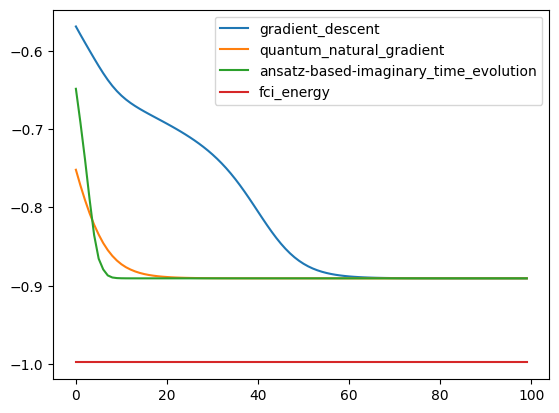

In [27]:
import matplotlib.pyplot as plt

fig = plt.figure()
for key in _dict.keys():
    plt.plot(np.arange(num_epochs), _dict[key], label=key)
plt.legend()
plt.show()
plt.close(fig)

We can see AITE converge much faster than gradient descent, which is in agreement with the argument in the paper.

Next we test the performance on LiH system.

In [28]:
import pandas as pd
_dict = {'gradient_descent': [], 'quantum_natural_gradient': [], 'ansatz-based-imaginary_time_evolution':[]}


num_epochs = 100
lr = 0.01

V = VQE(key='LiH', lr=lr)
for i in range(num_epochs):

    V.gradient_descent_step()
    E = V.eval()
    _dict['gradient_descent'].append(E.real)

V = VQE(key='LiH', lr=lr)
for i in range(num_epochs):
    V.imaginary_time_evolution_step()
    E = V.eval()
    _dict['ansatz-based-imaginary_time_evolution'].append(E.real)

V = VQE(key='LiH', lr=lr)
for i in range(num_epochs):
    V.natural_gradient_step()
    E = V.eval()
    _dict['quantum_natural_gradient'].append(E.real)

    
_dict['fci_energy'] = [V.fci_energy for _ in range(num_epochs)]
df = pd.DataFrame(_dict)
print(df)

/home/ma-user/anaconda3/envs/MindQuantum/lib/python3.7/site-packages/mindquantum/core/operators/hamiltonian.py:95: ComplexWarning: Casting complex values to real discards the imaginary part
  ham = mb.hamiltonian(self.ham_termlist)


    gradient_descent  quantum_natural_gradient  \
0          -3.903749                 -4.343222   
1          -3.909381                 -3.488069   
2          -3.914937                 -3.982792   
3          -3.920416                 -3.793857   
4          -3.925820                 -3.326120   
..               ...                       ...   
95         -4.258834                 -3.902654   
96         -4.262156                 -3.798148   
97         -4.265496                 -3.074122   
98         -4.268856                 -4.473872   
99         -4.272235                 -4.054311   

    ansatz-based-imaginary_time_evolution  fci_energy  
0                               -4.434035   -7.882362  
1                               -4.450479   -7.882362  
2                               -4.466405   -7.882362  
3                               -4.481886   -7.882362  
4                               -4.496907   -7.882362  
..                                    ...         ...  
95     

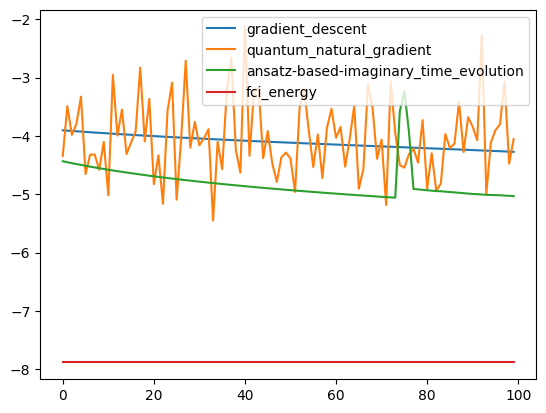

In [29]:
import matplotlib.pyplot as plt

fig = plt.figure()
for key in _dict.keys():
    plt.plot(np.arange(num_epochs), _dict[key], label=key)
plt.legend()
plt.show()
plt.close(fig)

## Summary

In this recurrence, we implemented the ansatz-based imaginary time evolution method and tested its performance on the VQE of the H2 and LiH systems. We proposed two methods to calculate the forward mode gradients: 1. use of an helper function 2. direct manipulation of the mindquantum circuit object. Our test shows that these two methods work well and provide exactly the same gradients as the reverse mode method built into mindquantum. To compute the Hessian-like preconditioner, we proposed a hybrid mode computation with only $𝑁$-pass for $𝑁$-parameters in addition to the widely used forward mode method with $𝑁^2$-pass for $𝑁$-parameters. The test shows that the method works well. In addition to the ansatz-based imaginary time evolution, we have also implemented the quantum natural gradient descent method and tested its performance.

Our experiment shows that the ansatz-based imaginary tme evolution method converges much faster than the gradient descent method, in agreement with the argument in the paper.